# Seminar 9 - Model Selection & Regularization

The task is to predict the fat content of a meat sample on the basis of its NIR absorbance spectrum. In real applications, the analysis of NIR-spectra is challenging and there is a wide range of analysis strategies.1 They typically involve principle component analysis (PCA) or make use of neural networks to infer chemical information (like fat content) from NIR-spectra. Here in this assignment it will do to apply multiple linear models with possibly some shrinkage involved.

- Read in the data with the command readRDS and store the dataframe under the name nirData.
- The data is formatted in «wide format». This means that each measurement has its own column: Check that you have indeed in total data of 215 meat samples with each a fat measurement (column fat) and 100 NIR-variables.
- From the full data set, set aside a subset of 25% of all observations as test data set and use the remaining 75% as training data. We explain below why we will not use here a separate validation data set.

In [1]:
data = readRDS("data/NIR_meat.rds")
head(data)

,fat,NIR1,NIR2,NIR3,NIR4,NIR5,NIR6,NIR7,NIR8,NIR9,⋯,NIR91,NIR92,NIR93,NIR94,NIR95,NIR96,NIR97,NIR98,NIR99,NIR100
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,22.5,2.624678,2.617141,2.661152,2.632626,2.600933,2.640948,2.612343,2.615394,2.636674,⋯,3.003346,2.993943,2.957721,2.930983,2.917586,2.902895,2.878649,2.860067,2.816934,2.814325
2,40.1,2.831254,2.824333,2.852733,2.834804,2.875328,2.856527,2.871460,2.863564,2.863543,⋯,3.302150,3.321843,3.286252,3.255096,3.258644,3.242529,3.230499,3.214022,3.189640,3.125834
3,8.4,2.574347,2.604083,2.591397,2.590455,2.584382,2.580690,2.599903,2.588648,2.599094,⋯,2.709575,2.686483,2.676513,2.652291,2.613180,2.618521,2.572596,2.590596,2.558228,2.528773
4,5.9,2.808672,2.841908,2.838851,2.820005,2.823712,2.821007,2.849189,2.846039,2.839051,⋯,3.004082,2.977812,2.974285,2.916183,2.908807,2.874201,2.844503,2.863643,2.827721,2.795507
5,25.5,2.789264,2.791681,2.788367,2.790700,2.807376,2.787763,2.801650,2.815338,2.809073,⋯,3.312566,3.307170,3.300364,3.253781,3.245728,3.212378,3.196019,3.181573,3.152868,3.134712
6,42.7,3.015988,3.001191,3.029782,3.052708,3.034373,3.029786,3.047315,3.043427,3.061366,⋯,3.582822,3.562521,3.570639,3.533749,3.524914,3.534874,3.499294,3.484862,3.467219,3.446953


In [2]:
# Test Train Split
set.seed(2023)
i <- sample(x=nrow(data), size = NROW(data)/4)
test <- dplyr::slice(data, i)
train <- dplyr::slice(data, -i)

## Visualizing

Visualize and describe the univariate sample distribution of fat content (column fat): what is the mean and the median fat content in the sample?

[1] 17.5284

[1] 12.6

[1] 155.029

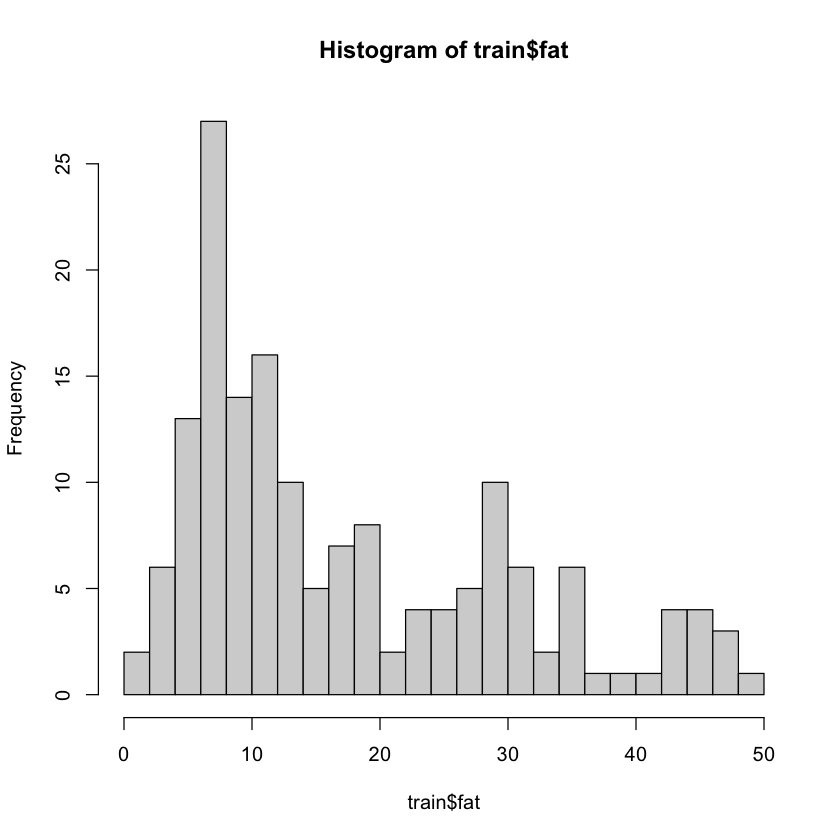

In [7]:
hist(train$fat, breaks=30)
mean(train$fat)
median(train$fat)
var(train$fat)

Each NIR-predictors (aka NIR-features) has its own variance. Across the features, what is the range of these variances? What is the mean variance?

In [8]:
vars <- c()
for (col in train[-1]) {
    vars <- c(vars, var(col))
}
max(vars)
min(vars)
mean(vars)

[1] 0.2756873

[1] 0.1541036

[1] 0.2430984

Look at the correlations among the NIR-features themselves and also the correlation with the response variable fat. Try to get an overview, for instance, by considering only — say — every 10th feature. What stands out?

## Linear Model
Fit an additive model with intercept and all available NIR-predictors on the training data and store the model fit. We will use this model as a reference in our benchmark of different models.

In [9]:
m.lm <- lm(fat ~ ., data = train)

In [10]:
summary(m.lm)


Call:
lm(formula = fat ~ ., data = train)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.1045 -1.2343  0.2291  1.1686  5.1911 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  20.0424     5.5543   3.608 0.000623 ***
NIR1         10.0683    30.3434   0.332 0.741169    
NIR2         25.4289    24.6740   1.031 0.306799    
NIR3        -35.9336    27.8005  -1.293 0.201041    
NIR4         19.0628    31.3012   0.609 0.544779    
NIR5        -37.2157    30.0092  -1.240 0.219673    
NIR6        -29.4103    26.9023  -1.093 0.278594    
NIR7         24.3261    30.6364   0.794 0.430258    
NIR8         10.6327    24.3081   0.437 0.663355    
NIR9         54.4140    27.6789   1.966 0.053866 .  
NIR10        14.1811    35.1660   0.403 0.688165    
NIR11       -41.0173    33.4085  -1.228 0.224257    
NIR12        20.1472    33.1033   0.609 0.545039    
NIR13       -33.3652    28.5899  -1.167 0.247741    
NIR14       -52.1544    28.8415  -1.808 0.075488 .  


## Variable Selection
All absorbance predictors are potentially relevant predictors for fat-level and hence the full linear model seems like the best linear additive model. Nevertheless, we try out two variable selection methods to build two simpler regression models.

### Using AIC
The R-function step uses — starting from the provided model fit — the AIC-criterion to decide if dropping or adding a variable improves the model. The AIC-criterion balances model fit on the training data with model complexity. Lower values of AIC indicate better fits. For a fitted model with p parameters, AIC is defined as 

$AIC = −2 × max(loglikelihood) + 2 × p$

In [11]:
m.aic <- step(m.lm, direction = "both", k = 2, trace = 0)

In [12]:
# 53 predictors left
m.aic


Call:
lm(formula = fat ~ NIR2 + NIR3 + NIR4 + NIR5 + NIR7 + NIR9 + 
    NIR11 + NIR13 + NIR14 + NIR15 + NIR18 + NIR19 + NIR20 + NIR21 + 
    NIR26 + NIR29 + NIR30 + NIR31 + NIR32 + NIR33 + NIR36 + NIR38 + 
    NIR40 + NIR42 + NIR43 + NIR44 + NIR45 + NIR47 + NIR48 + NIR50 + 
    NIR51 + NIR53 + NIR54 + NIR55 + NIR57 + NIR59 + NIR63 + NIR66 + 
    NIR67 + NIR69 + NIR70 + NIR72 + NIR74 + NIR75 + NIR78 + NIR79 + 
    NIR80 + NIR84 + NIR89 + NIR92 + NIR94 + NIR97 + NIR98, data = train)

Coefficients:
(Intercept)         NIR2         NIR3         NIR4         NIR5         NIR7  
      21.47        29.07       -25.27        35.22       -42.61        29.40  
       NIR9        NIR11        NIR13        NIR14        NIR15        NIR18  
      45.74       -27.20       -50.51       -52.74        34.12        34.73  
      NIR19        NIR20        NIR21        NIR26        NIR29        NIR30  
      20.33        20.99       -47.67       -43.95       -64.00       -44.66  
      NIR31        NIR32

### Using BIC
Use the parameter $k$ of the step-function to adjust the penalization factor to get BIC instead of AIC as variable selection criterion. Confirm that the resulting model is sparser than the model selected by AIC.
How many predictors in the BIC-model are statistically significant at the significance level of 5%?

In [13]:
m.bic <- step(m.lm, direction = "both", k = log(length(train)), trace = 0)

In [14]:
m.bic


Call:
lm(formula = fat ~ NIR4 + NIR13 + NIR21 + NIR26 + NIR29 + NIR30 + 
    NIR40 + NIR42 + NIR45 + NIR50 + NIR74 + NIR92 + NIR38, data = train)

Coefficients:
(Intercept)         NIR4        NIR13        NIR21        NIR26        NIR29  
      23.64        66.86       -47.55       -43.28       -41.45       -54.20  
      NIR30        NIR40        NIR42        NIR45        NIR50        NIR74  
     -36.55        38.89        72.29        66.70       -48.80       -48.72  
      NIR92        NIR38  
      31.94        41.92  


## Shrinkage Methods
Variable selection either keeps a variable or drops it completely from the model, — it is either-or. The R-package `glmnet` allows for different ways to continuously shrink parameter coefficient estimates of a linear regression model. The main functions of the package are `glmnet` and `cv.glmnet`.

Within these functions the parameter alpha= specifies the type of continuous penalization:

- `alpha=0` corresponds to ridge regression.
- `alpha=1` is Lasso-regression.
- a value between 0 and 1 corresponds to a mixture of ridge and Lasso-regression and this approach to penalization is called elastic net.

In [15]:
library("glmnet")
library("dplyr")

y_glm_train <- train |> dplyr::pull(fat)
x_glm_train <- train |> dplyr::select(!fat) |> as.matrix()
y_glm_test <- test |> dplyr::pull(fat)
x_glm_test <- test |> dplyr::select(!fat) |> as.matrix()

Loading required package: Matrix

Loaded glmnet 4.1-8


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




Concretely, fit three different models in the following order:
- Ridge regression
- Lasso-regression
- Elastic net as mixture of ridge and Lasso-regression, with mixing parameter $α$ = 0.3. (With $α$ = 0.3, we choose a stronger contribution of ridge regression because we have so strongly correlated predictors where ridge regression is designed for.)

In [16]:
m.glm_ridge <- cv.glmnet(x_glm_train, y_glm_train, alpha = 0)
m.glm_lasso <- cv.glmnet(x_glm_train, y_glm_train, alpha = 1)
m.glm_elastic <- cv.glmnet(x_glm_train, y_glm_train, alpha = 0.3)

Identify for each of the three models classes the value for the penalization parameter $λ$ so that the cross-validated prediction error is within one standard error of the minimum prediction error.

How are the model coefficients affected by the penalization? Compare the estimated coefficients with those from the full linear model.

## Model Assessment
We have fitted different models on the NIR-training data. Now, we want to use the reserved test data to assess these models.

In [17]:
mse <- function(predictions, actual) sum((predictions - actual)^2) / length(actual)

In [18]:
mse(predict(m.glm_elastic, newx = x_glm_test), y_glm_test)

[1] 11.50588

In [19]:
mse(predict(m.glm_lasso, newx = x_glm_test), y_glm_test)

[1] 11.62717

In [20]:
mse(predict.lm(m.bic, newdata = test), test$fat)

[1] 14.66285

In [21]:
mse(predict.lm(m.aic, newdata = test), test$fat)

[1] 24.98341

In [22]:
mse(predict(m.glm_ridge, newx = x_glm_test), y_glm_test)

[1] 26.24767

In [23]:
mse(predict.lm(m.lm, newdata = test), test$fat)

[1] 31.092

### Ranking
1. Elastic with $\alpha = 0.3$
2. Lasso
3. BIC
5. AIC
4. Ridge
6. Simple LM

# Practice Test

In [20]:
min(m.lm$coefficients)
max(m.lm$coefficients)

[1] -86.57411

[1] 61.71187

In [21]:
length(m.aic$coefficients)

[1] 54

In [22]:
length(m.bic$coefficients)

[1] 14

In [23]:
m.glm_ridge


Call:  cv.glmnet(x = x_glm_train, y = y_glm_train, alpha = 0) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min 0.8898    96   29.39 4.648     100
1se 1.2909    92   34.00 5.265     100

In [24]:
m.glm_ridge_lambda <- cv.glmnet(x_glm_train, y_glm_train, lambda = c(0.8898, 1.1762), alpha = 0)

In [25]:
print(m.glm_ridge_lambda)


Call:  cv.glmnet(x = x_glm_train, y = y_glm_train, lambda = c(0.8898,      1.1762), alpha = 0) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min 0.8898     2   28.65 3.791     100
1se 0.8898     2   28.65 3.791     100


# Best Linear Model

Try to optimize $\alpha$ in the elasticnet glmnet

In [24]:
optim_alpha <- function (alpha) {
    best <- cv.glmnet(x_glm_train, y_glm_train, alpha = alpha)
    mse(predict(best, newx = x_glm_test), y_glm_test)
}

In [25]:
optimize(optim_alpha, interval = c(0.01, 0.99))

$minimum
[1] 0.7893834

$objective
[1] 11.3594

That only tells us the value of $\alpha = 0.6$ is probably best.

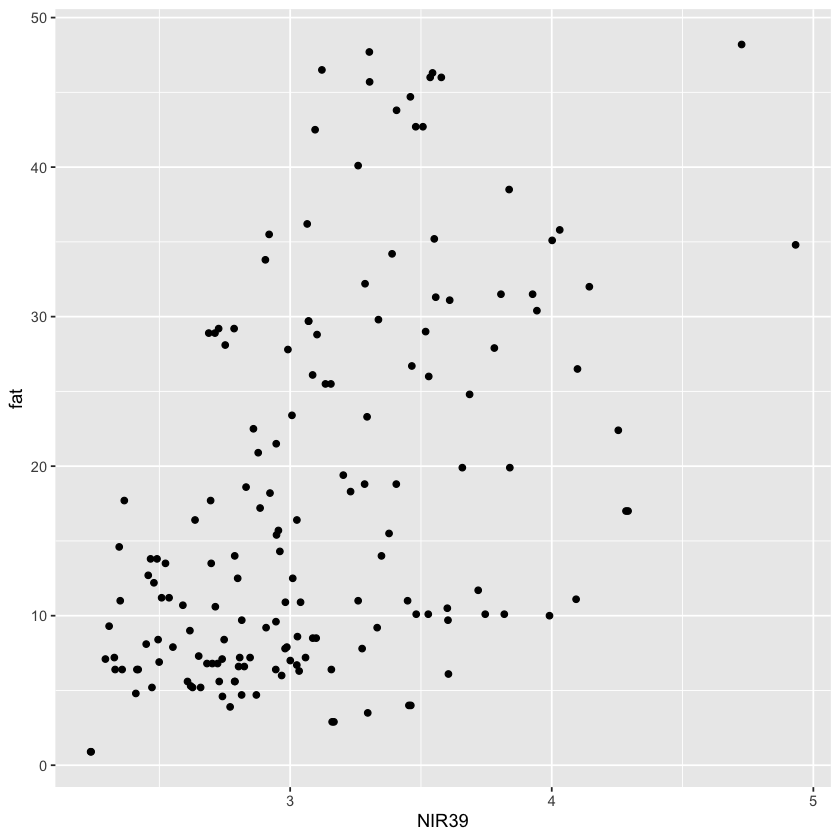

In [26]:
library("ggplot2")
ggplot(train, map = aes(x = NIR39, y = fat)) + geom_point()

In [27]:
m <- cv.glmnet(x_glm_train, y_glm_train, alpha = 0.6)
mse(predict(m, newx = x_glm_test), y_glm_test)

[1] 11.39355

In [37]:
library("tidymodels")
linear_reg() %>% set_engine("keras")
rand_forest(mode = "regression")

Linear Regression Model Specification (regression)

Computational engine: keras 


Random Forest Model Specification (regression)

Computational engine: ranger 


In [29]:
# Linear Model from TidyModels
m.tidy_lm <- linear_reg() %>% fit(fat ~ ., data = train)
mse(predict(m.tidy_lm, new_data = test), test$fat)

[1] 31.092

In [30]:
m.tidy_glm <- linear_reg(penalty = 0.6, mixture = 0.3) %>% fit(fat ~ ., data = train)
mse(predict(m.tidy_glm, new_data = test), test$fat)

[1] 31.092

In [31]:
# Random Forest from TidyModels
m.tidy_rf <- rand_forest(mode = "regression", min_n = 3) %>% fit(fat ~ ., data = train)
mse(predict(m.tidy_rf, new_data = test), test$fat)

[1] 54.14495

In [32]:
xx = data.frame(as.matrix(coef(m.glm_elastic))[-1] * x_glm_test)
m.tidy_rf_glm <- rand_forest(mode = "regression", trees = 200) %>% 
    fit_xy(x = xx, y = train$fat)
mse(predict(m.tidy_rf_glm, new_data = test), test$fat)

[1] 276.3708

In [33]:
THRESH = 3.0

train1 = subset(train, train$NIR39 > THRESH)
y_glm_train1 <- train1 |> dplyr::pull(fat)
x_glm_train1 <- train1 |> dplyr::select(!fat) |> as.matrix()

train2 = subset(train, train$NIR39 < THRESH)
y_glm_train2 <- train2 |> dplyr::pull(fat)
x_glm_train2 <- train2 |> dplyr::select(!fat) |> as.matrix()

test1 = subset(test, test$NIR39 < THRESH)
y_glm_test1 <- test1 |> dplyr::pull(fat)
x_glm_test1 <- test1 |> dplyr::select(!fat) |> as.matrix()

test2 = subset(test, test$NIR39 < THRESH)
y_glm_test2 <- test2 |> dplyr::pull(fat)
x_glm_test2 <- test2 |> dplyr::select(!fat) |> as.matrix()

optim_train1 <- function (alpha) {
    best <- cv.glmnet(x_glm_train1, y_glm_train1, alpha = alpha)
    mse(predict(best, newx = x_glm_test1), y_glm_test1)
}

optim_train2 <- function (alpha) {
    best <- cv.glmnet(x_glm_train2, y_glm_train2, alpha = alpha)
    mse(predict(best, newx = x_glm_test2), y_glm_test2)
}

In [90]:
a_1 <- optimize(optim_train1, interval = c(0.01, 0.99))
a_2 <- optimize(optim_train2, interval = c(0.01, 0.99))

m_train1 <- cv.glmnet(x_glm_train1, y_glm_train1, alpha = a_1$minimum)
m_train2 <- cv.glmnet(x_glm_train2, y_glm_train2, alpha = a_2$minimum)

In [91]:
preds <- c()
for (r in c(1:53)) {
    row = x_glm_test[r,]
    if (row[39] > THRESH) {
        preds <- c(preds, predict(m_train1, newx=row))
    } 
    if (row[39] < THRESH) {
        preds <- c(preds, predict(m_train2, newx=row))
    }
}

In [92]:
mse(preds, y_glm_test)

[1] 8.575722

## Non-Linear Models

In [166]:
library("brulee")

In [301]:
NORM = TRUE

train_norm = train
if (NORM) train_norm = (train_norm - min(train_norm))/ range(train_norm)[2]

mlp <- brulee_mlp(
    fat ~ NIR4 + NIR13 + NIR21 + NIR26 + NIR29 + NIR30 + NIR40 + NIR42 + NIR45 + NIR50 + NIR74 + NIR92 + NIR38,
    data = train_norm,
    hidden_units = c(20, 10),
    epochs = 2000,
    learn_rate = 0.001
)

test_norm = test
if (NORM) test_norm = (test_norm - min(test_norm))/ range(test_norm)[2]

mlp_pred = predict(mlp, test_norm)
if (NORM) mlp_pred$.pred = (mlp_pred$.pred * range(test)[2]) + min(test)

mse(mlp_pred$.pred, test$fat)

[1] 184.3681

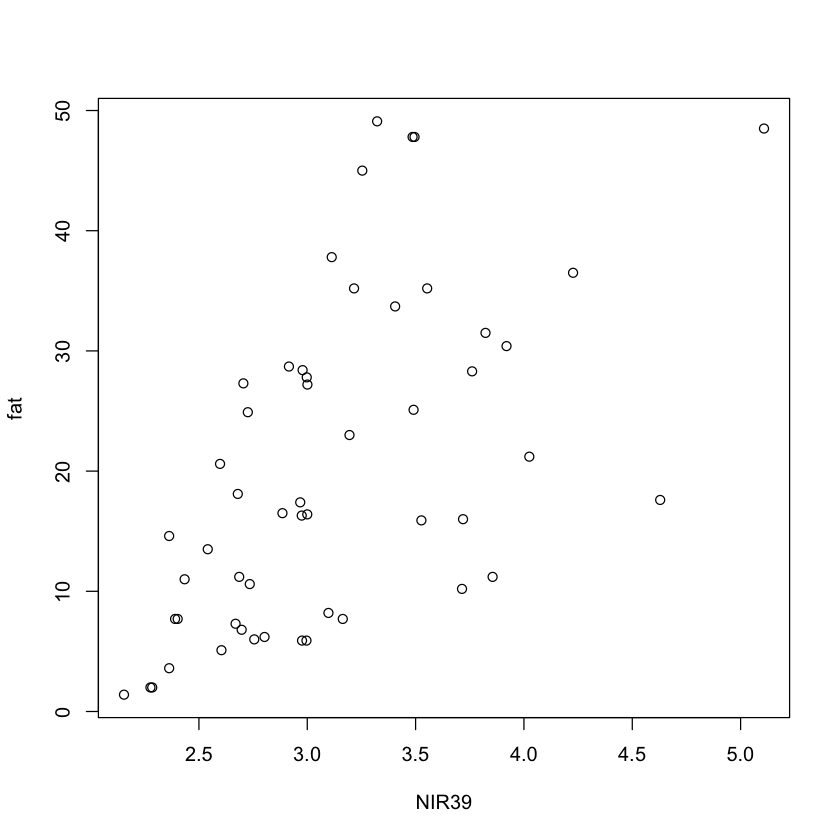

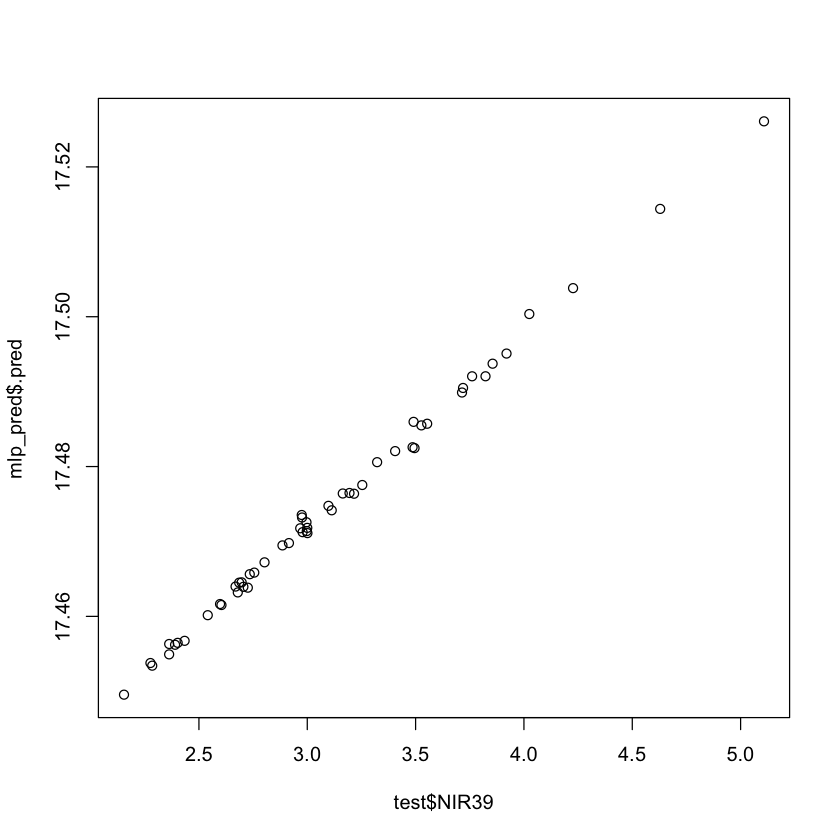

In [247]:
plot(fat ~ NIR39, data = test)
plot(x = test$NIR39, y = mlp_pred$.pred)

In [352]:
library("torch")
library("luz")

x_train_t <- train |> dplyr::select(!fat) |> as.matrix() |> torch_tensor()
y_train_t <- train |> dplyr::pull(fat) |> torch_tensor() |> torch_unsqueeze(dim=1)

x_test_t <- test |> dplyr::select(!fat) |> as.matrix() |> torch_tensor()
y_test_t <- test |> dplyr::pull(fat) |> torch_tensor() |> torch_unsqueeze(dim=1)

train_ds <- tensor_dataset(x_train_t, y_train_t)
test_ds <- tensor_dataset(x_test_t, y_test_t)

train_dl <- dataloader(train_ds, batch_size = 4, shuffle = TRUE)
test_dl <- dataloader(test_ds, batch_size = 4, shuffle = TRUE)

In [349]:
net <- nn_module(
  initialize = function(d_in, d_hidden, d_out) {
    self$net <- nn_sequential(
      nn_linear(d_in, d_hidden),
      nn_relu(),
      nn_linear(d_hidden, d_hidden),
      nn_relu(),
      nn_linear(d_hidden, d_out)
    )
  },
  forward = function(x) {
    self$net(x)
  }
)

In [ ]:
# dimensionality of hidden layer
d_hidden <- 32
# output dimensionality (number of predicted features)
d_out <- 1

fitted <- net |>
  setup(
    loss = nn_mse_loss(), 
    optimizer = optim_adam
  ) |>
  set_hparams(
    d_in = 100,
    d_hidden = d_hidden, 
    d_out = d_out
  ) |>
  fit(train_dl, epochs = 10, valid_data = test_dl)

fitted